### Import Dependencies

In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Loading Dataset and EDA

In [2]:
df = pd.read_csv("/content/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

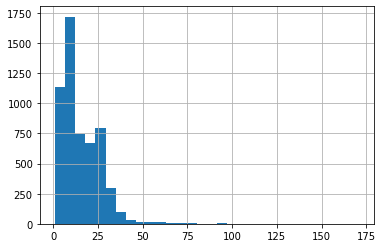

In [5]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['text']]

pd.Series(seq_len).hist(bins = 30)

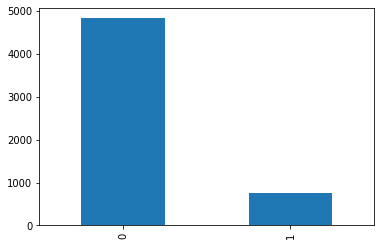

In [6]:
# Visualize label distribution
df['label'].value_counts().plot(kind = 'bar')

### Split Dataset: 

Training 0.7; Validation: 0.15; Testing: 0.15

In [7]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [8]:
print('sentiment Text: ', train_text[0])
print('sentiment: ', train_labels[0])

sentiment Text:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
sentiment:  0


### Data Preprocessing, Tokenizing 

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
max_vocab = 100000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(train_text)

In [11]:
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

The size of datatset vocab is:  7408


In [12]:
train_seq = tokenizer.texts_to_sequences(train_text)
val_seq = tokenizer.texts_to_sequences(val_text)
test_seq = tokenizer.texts_to_sequences(test_text)
print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])
print('Val sequence: ', val_seq[0])

Training sequence:  [1827, 2320, 43, 2321, 293, 231, 1828, 21, 2321, 2322, 35, 4, 669, 2323, 48, 222, 3508, 48, 4, 792, 74, 3509, 2, 134, 2320, 4, 21, 1827, 3510, 166, 3511, 263]
Testing sequence:  [450, 3, 26, 3, 3502, 535, 5, 3962]
Val sequence:  [3236, 619, 3120, 112, 172, 13, 908, 11, 67]


In [13]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

The length of training sequence is:  162


In [14]:
pad_val = pad_sequences(val_seq, maxlen=T)
print('The length of testing sequence is: ', pad_val.shape[1])

The length of testing sequence is:  162


In [15]:
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])

The length of testing sequence is:  162


### Build Model

In [20]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.models import Model

In [21]:
D = 50 

input = Input (shape=(T, ))   
x = Embedding(V+1, D)(input)    # V+1 because the indexing of the words in vocab (V) start from 1 not 0
x = SpatialDropout1D(0.1)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

### Model Train

In [22]:
model = Model(input, output)

# compiling the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [23]:
# training the model
history = model.fit(pad_train, train_labels, validation_data=(pad_val, val_labels), epochs=5)

Epoch 1/5
122/122 [==============================] - 17s 71ms/step - loss: 0.4101 - accuracy: 0.8608 - val_loss: 0.2876 - val_accuracy: 0.8660
Epoch 2/5
122/122 [==============================] - 8s 64ms/step - loss: 0.0923 - accuracy: 0.9664 - val_loss: 0.0527 - val_accuracy: 0.9844
Epoch 3/5
122/122 [==============================] - 8s 64ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.0498 - val_accuracy: 0.9856
Epoch 4/5
122/122 [==============================] - 8s 63ms/step - loss: 0.0098 - accuracy: 0.9977 - val_loss: 0.0459 - val_accuracy: 0.9868
Epoch 5/5
122/122 [==============================] - 8s 63ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0457 - val_accuracy: 0.9868


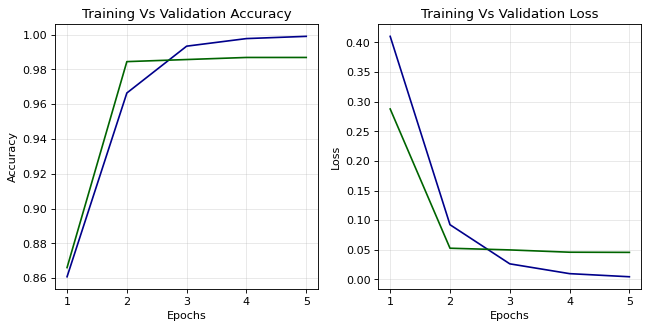

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4), dpi=80)

ax[0].plot(epochs, acc, label = "Training Accuracy", color='darkblue')
ax[0].plot(epochs, val_acc, label = "Validation Accuracy", color='darkgreen')
ax[0].grid(alpha=0.3)
ax[0].title.set_text('Training Vs Validation Accuracy')
plt.setp(ax[0], xlabel='Epochs')
plt.setp(ax[0], ylabel='Accuracy')


ax[1].plot(epochs, loss, label = "Training Loss", color='darkblue')
ax[1].plot(epochs, val_loss, label = "Validation Loss", color='darkgreen')
ax[1].grid(alpha=0.3)
ax[1].title.set_text('Training Vs Validation Loss')
plt.setp(ax[1], xlabel='Epochs')
plt.setp(ax[1], ylabel='Loss')

plt.show()

### Model Evaluation

In [25]:
model.evaluate(pad_test, test_labels)

27/27 [==============================] - 1s 24ms/step - loss: 0.0526 - accuracy: 0.9880


[0.05264073237776756, 0.9880383014678955]

In [26]:
test_predict = model.predict(pad_test)
test_predict = test_predict.flatten()


In [27]:
from sklearn.metrics import precision_recall_curve
from numpy import argmax

In [28]:
precision, recall, thresholds = precision_recall_curve(test_labels, test_predict)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.493420, F-Score=0.959


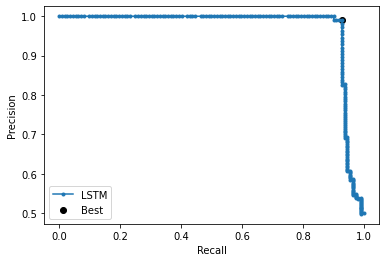

In [29]:
plt.plot(recall, precision, marker='.', label='LSTM')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [30]:
import numpy as np
test_predict = np.where(test_predict>0.222681, 1,0)
test_predict

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,

In [31]:
# confusion matrix
pd.crosstab(test_labels, test_predict)

col_0,0,1
label,,
0,721,3
1,8,104


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

In [33]:

print(classification_report(test_labels, test_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       724
           1       0.97      0.93      0.95       112

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



In [34]:
cm = confusion_matrix(test_labels, test_predict)

Text(33.0, 0.5, 'Truth')

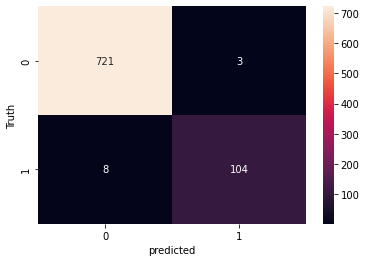

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm,annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [36]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, test_predict, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

In [37]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(test_labels, test_predict)

print(auc_score1)

0.9622138910812944


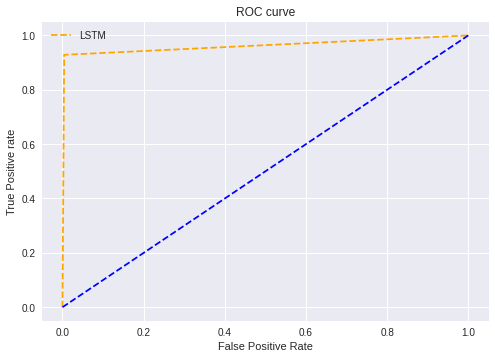

In [38]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LSTM')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();